Visualization of G and D matrices for unimanual conditions

In [1]:
import os
import glob
import sys
sys.path.append('/Users/aghavamp/Desktop/Projects')
sys.path.append('/Users/aghavamp/Desktop/Projects/bimanual_wrist')
sys.path.append('/Users/aghavamp/Desktop/Projects/Functional_Fusion')
sys.path.append('/Users/aghavamp/Desktop/Projects/PcmPy')
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



# PCM

Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4


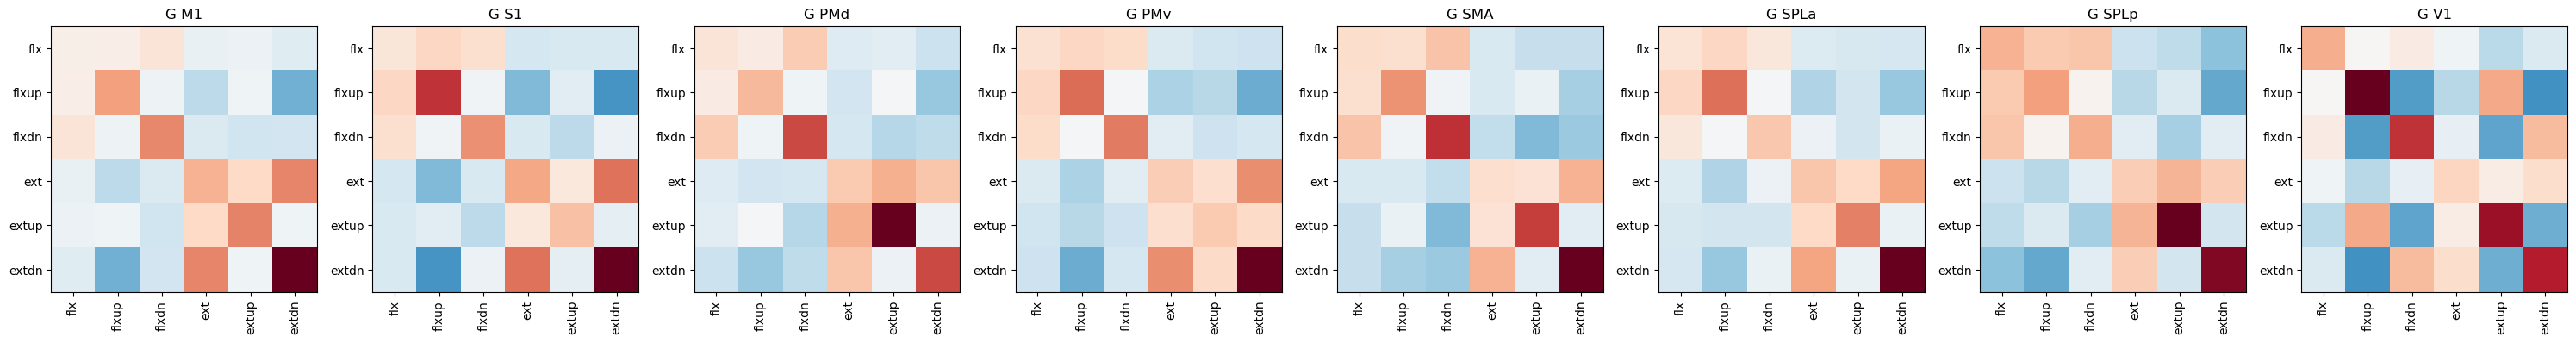

In [ ]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
cmap = 'RdBu_r' 
sn_bad = []
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
conditions = ['rhand','lhand']

fig, axes = plt.subplots(1, len(regions), figsize=(30,6))
for i_region, region in enumerate(regions):
    rois = [f'{region}_R', f'{region}_L']
    data, cond_vec, part_vec = [], [], []
    for roi, condition in zip(rois, conditions):
        file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
        d = np.load(file_path, allow_pickle=True)

        subject = d['subject']
        indices = [k for k, s in enumerate(subject) if s not in sn_bad]

        subject = d['subject'][indices]
        cond_name_tmp = d['cond_intrinsic_vec'][indices]
        cond_vec_tmp = d['cond_num_vec'][indices]
        data_tmp = d['beta_white'][indices]
        part_tmp = d['part_vec'][indices]

        for i_sub in range(len(subject)):
            # Filter for the current condition
            if condition == 'lhand_marginal':
                Y = []
                subj_part = []
                subj_cond = []
                # loop on each direction
                for cond_num, direction in enumerate(labels):
                    # in each partition:
                    for k in range(1,11):
                        # bimanual trials that left hand goes in that direction:
                        tmp_name = f'bi:{direction}_'
                        idx1 = np.array([(tmp_name in tmp) for tmp in cond_name_tmp[i_sub]])
                        idx2 = np.array([(k == tmp) for tmp in part_tmp[i_sub]])
                        idx = idx1 & idx2
                        y_tmp = np.mean(data_tmp[i_sub][idx,:], axis=0)
                        Y = np.vstack((Y, y_tmp)) if len(Y) else y_tmp
                    subj_part = np.int64(np.concatenate((subj_part,np.arange(1,11))))
                    condition_name = f'lhand:{direction}'
                    # find the condition numbers corresponding to this condition:
                    idx = (cond_name_tmp[i_sub] == condition_name) & (part_tmp[i_sub] == 1)
                    subj_cond.extend([cond_vec_tmp[i_sub][idx][0]] * 10)

            if condition == 'rhand_marginal':
                Y = []
                subj_part = []
                subj_cond = []
                # loop on each direction
                for cond_num, direction in enumerate(labels):
                    # in each partition:
                    for k in range(1,11):
                        # bimanual trials that right hand goes in that direction:
                        tmp_name = f'_{direction}'
                        idx1 = np.array([(tmp_name in tmp) for tmp in cond_name_tmp[i_sub]])
                        idx2 = np.array([(k == tmp) for tmp in part_tmp[i_sub]])
                        idx = idx1 & idx2
                        y_tmp = np.mean(data_tmp[i_sub][idx,:], axis=0)
                        Y = np.vstack((Y, y_tmp)) if len(Y) else y_tmp
                    subj_part = np.int64(np.concatenate((subj_part,np.arange(1,11))))
                    condition_name = f'rhand:{direction}'
                    # find the condition numbers corresponding to this condition:
                    idx = (cond_name_tmp[i_sub] == condition_name) & (part_tmp[i_sub] == 1)
                    subj_cond.extend([cond_vec_tmp[i_sub][idx][0]] * 10)

            if condition == 'lhand' or condition == 'rhand':
                # Filter for the current condition
                idx = [j for j, c in enumerate(cond_name_tmp[i_sub]) if condition in c]
                Y = data_tmp[i_sub][idx, :]
                subj_cond = cond_vec_tmp[i_sub][idx]
                subj_part = part_tmp[i_sub][idx]

            data.append(Y)
            cond_vec.append(np.array(subj_cond))
            part_vec.append(subj_part)

    Y = []
    # --- RDM Calculation ---
    for i_sub in range(len(data)):
        obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
        Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))

    ncond = 6

    # Null model - no information:
    cov = np.zeros((ncond, ncond))
    M_null = pcm.model.FixedModel('null', cov)

    # indepdent model
    cov = np.eye(ncond)
    cov = cov/np.trace(np.eye(ncond))
    # double center the model:
    M_indep = pcm.model.FixedModel('independent', cov)

    # mirror midline model:
    covs = np.tile(np.eye(ncond//2), (2,2))
    covs = covs / np.trace(covs)
    M_mirror = pcm.model.FixedModel('mirror indep', covs)

    # Cosine tuning curve model:
    angles_deg = np.array([0, 60, 300, 180, 120, 240], dtype=float)
    delta = np.deg2rad(angles_deg[:, None] - angles_deg[None, :])
    corr = np.cos(delta)        # Correlation: normalized to unit variance
    corr = corr / np.trace(corr)
    M_cosine = pcm.model.FixedModel('cosine tuning', corr)

    # noise ceiling model:
    M_ceil = pcm.model.FreeModel('ceil',ncond)

    M = [M_null, M_indep, M_mirror, M_cosine, M_ceil]

    T_gr, theta_gr = pcm.fit_model_group(Y, M, fit_scale=True)

    G,_ = M[-1].predict(theta_gr[-1][:M[-1].n_param])
    vmin = -np.max(np.abs(G))
    vmax = np.max(np.abs(G))
    axes[i_region].imshow(G, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    # plt.colorbar(axes[i_region].imshow(G, cmap='RdBu_r', vmin=vmin, vmax=vmax), ax=axes[i_region])
    axes[i_region].set_title(f'G {region}')
    axes[i_region].set_xticks([0,1,2,3,4,5])
    axes[i_region].set_xticklabels(labels, rotation=90)
    axes[i_region].set_yticks([0,1,2,3,4,5])
    axes[i_region].set_yticklabels(labels)
    # D = pcm.G_to_dist(G)
    # vmin = -np.max(np.abs(D))
    # vmax = np.max(np.abs(D))
    # plt.imshow(D, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    # plt.colorbar(axes[i_region].imshow(D, cmap='RdBu_r', vmin=vmin, vmax=vmax), ax=axes[i_region])
    # plt.title(f'D {region}')
    # axes[i_region].set_xticks([0,1,2,3,4,5])
    # axes[i_region].set_xticklabels(labels, rotation=90)
    # axes[i_region].set_yticks([0,1,2,3,4,5])
    # axes[i_region].set_yticklabels(labels)
plt.tight_layout()
plt.show()




# MDS

In [ ]:
from sklearn.manifold import MDS
def apply_mds(D, n_components=2, metric=True):
    mds = MDS(n_components=n_components, dissimilarity='precomputed', metric=metric, random_state=42)
    embedding = mds.fit_transform(D)
    return embedding

G,_ = M[-1].predict(theta_gr[-1][:M[-1].n_param])
D = pcm.G_to_dist(G)
embedding = apply_mds(D, n_components=2, metric=True)
print(embedding)  # Outputs the 2D coordinates for each condition

plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c='blue')
for i, (x, y) in enumerate(embedding):
    plt.text(x + 0.0002, y + 0.0002, f'{labels[i]}', fontsize=12)  # Adjust offset if needed
plt.title('MDS 2D Representation of Conditions')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.grid(True)
plt.show()


from mpl_toolkits.mplot3d import Axes3D
embedding = apply_mds(D, n_components=3, metric=True)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c='red')
for i, (x, y, z) in enumerate(embedding):
    ax.text(x, y, z, f'{labels[i]}', size=10)
ax.set_title('MDS 3D Representation of Conditions')
ax.set_xlabel('MDS Dimension 1')
ax.set_ylabel('MDS Dimension 2')
ax.set_zlabel('MDS Dimension 3')
plt.show()


# Add this at the top for interactivity
%matplotlib widget  

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import MDS

G,_ = M[-1].predict(theta_gr[-1][:M[-1].n_param])
D = pcm.G_to_dist(G)
embedding = apply_mds(D, n_components=3, metric=True)
center = np.mean(embedding, axis=0)
embedding -= center  # Center the points

# Create interactive 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c='red')
ax.scatter(0, 0, 0, c='black', s=50)  # Mark the center
for i, (x, y, z) in enumerate(embedding):
    ax.text(x, y, z, f'{labels[i]}', size=10)
ax.set_title('Interactive MDS 3D Representation')
ax.set_xlabel('MDS Dimension 1')
ax.set_ylabel('MDS Dimension 2')
ax.set_zlabel('MDS Dimension 3')

plt.show()  # Now you can click-drag to rotate!



# Per subject

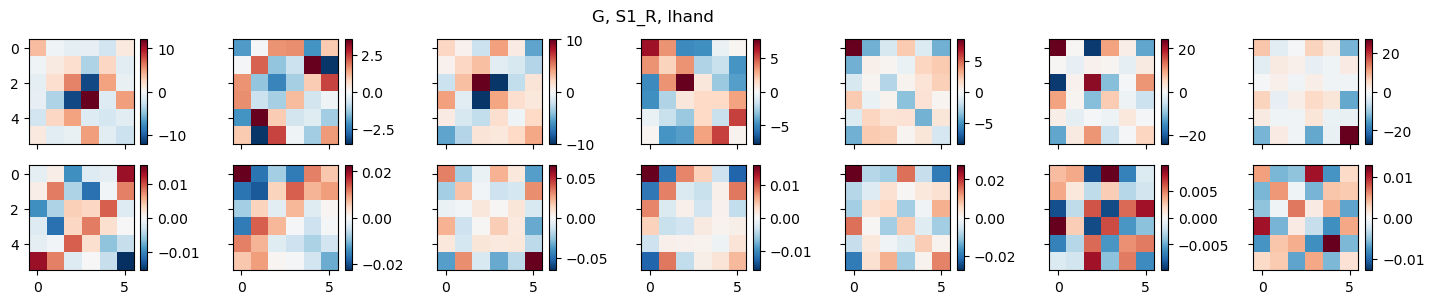

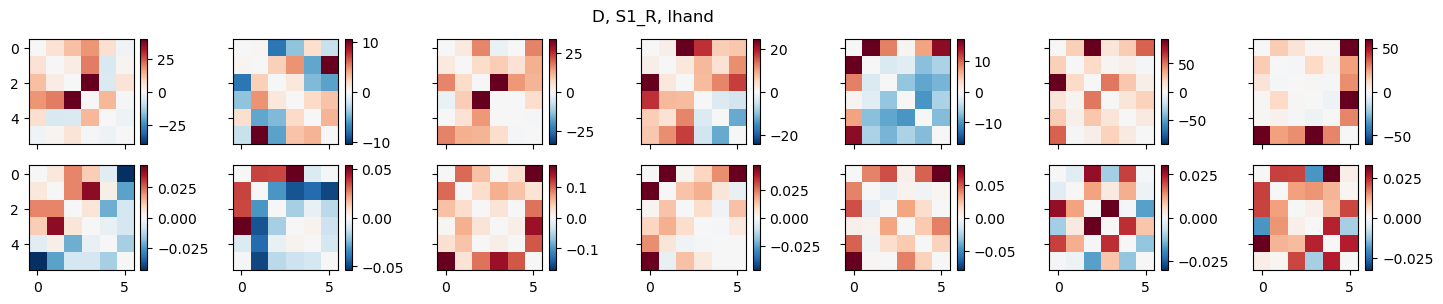

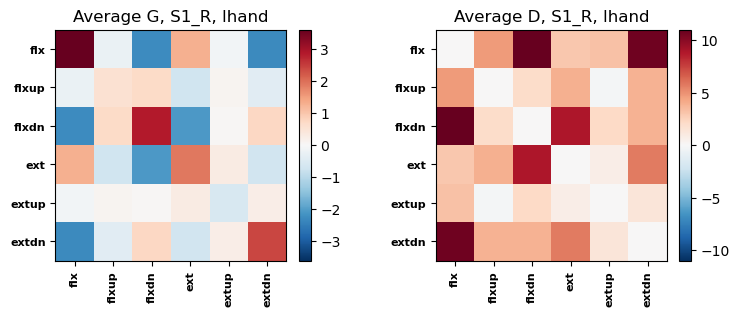

In [5]:
roi = 'S1_R'
condition = 'lhand'

sn_bad = []

loaded = np.load(os.path.join(analysisDir, f'pwbeta_{roi}.npz'), allow_pickle=True)
subject = loaded['subject']
indices = [i for i, s in enumerate(subject) if s not in sn_bad]
subject = loaded['subject'][indices]
cond_name_tmp = loaded['cond_intrinsic_vec'][indices]
cond_vec_tmp = loaded['cond_num_vec'][indices]
data_tmp = loaded['beta_white'][indices]
part_tmp = loaded['part_vec'][indices]

data = []
cond_name = []
cond_vec = []
part_vec = []
for i in range(len(subject)):
    # select only the condition of interest
    idx = [j for j, c in enumerate(cond_name_tmp[i]) if condition in c]
    data.append(data_tmp[i][idx, :])
    cond_name.append(cond_name_tmp[i][idx])
    cond_vec.append(cond_vec_tmp[i][idx])
    part_vec.append(part_tmp[i][idx])

Y = list()
for i in range(len(data)):
    obs_des = {'cond_vec': cond_vec[i],
               'part_vec': part_vec[i]}
    Y.append(pcm.dataset.Dataset(data[i],obs_descriptors = obs_des))

# Estimate and plot the second moment matrices across all data sets
N=len(Y)
ncond = len(np.unique(Y[0].obs_descriptors['cond_vec']))
G_hat = np.zeros((N,ncond,ncond))
for i in range(N):
    G_hat[i,:,:],_ = pcm.est_G_crossval(Y[i].measurements,
                            Y[i].obs_descriptors['cond_vec'],
                            Y[i].obs_descriptors['part_vec'],
                            X=pcm.matrix.indicator(Y[i].obs_descriptors['part_vec']))
    

cmap = 'RdBu_r'
fig, axs = plt.subplots(nrows=2, ncols=7, figsize=(18,3), sharex=True, sharey=True)
# show all second moment matrices
for i in range(N):
    # Determine the correct subplot axis
    ax = axs[i // 7, i % 7]
    
    # Calculate color limits for the current matrix
    vmin = G_hat[i,:,:].min()
    vmax = G_hat[i,:,:].max()
    vmax_abs = max(abs(vmax), abs(vmin))
    
    # 1. Capture the mappable object returned by imshow()
    im = ax.imshow(G_hat[i,:,:], vmin=-vmax_abs, vmax=vmax_abs, cmap=cmap)
    
    # 2. Add a colorbar specifically for this subplot
    # The 'ax' argument links the colorbar to the correct subplot 'ax'
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, aspect=15)
# plt.tight_layout(rect=[0, 0, 1, 0.96]) 
fig.suptitle(f'G, {roi}, {condition}')
plt.show()

cmap = 'RdBu_r'
fig, axs = plt.subplots(nrows=2, ncols=7, figsize=(18,3), sharex=True, sharey=True)
# show all second moment matrices
for i in range(N):
    D = pcm.G_to_dist(G_hat[i,:,:])
    # Determine the correct subplot axis
    ax = axs[i // 7, i % 7]
    
    # Calculate color limits for the current matrix
    vmin = D.min()
    vmax = D.max()
    vmax_abs = max(abs(vmax), abs(vmin))
    
    # 1. Capture the mappable object returned by imshow()
    im = ax.imshow(D, vmin=-vmax_abs, vmax=vmax_abs, cmap=cmap)
    
    # 2. Add a colorbar specifically for this subplot
    # The 'ax' argument links the colorbar to the correct subplot 'ax'
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, aspect=15)
# plt.tight_layout(rect=[0, 0, 1, 0.96]) 
fig.suptitle(f'D, {roi}, {condition}')
plt.show()

# average second moment matrix:
G_hat_avg = np.mean(G_hat, axis=0)
vmin = G_hat_avg.min()
vmax = G_hat_avg.max()
vmax_abs = max(abs(vmax), abs(vmin))
fig, ax = plt.subplots(1,2, figsize=(9,3))
ax[0].imshow(G_hat_avg, vmin=-vmax_abs, vmax=vmax_abs, cmap=cmap)
ax[0].set_title(f'Average G, {roi}, {condition}')
# set xticks:
labels = ['flx','flxup','flxdn','ext','extup','extdn']
ax[0].set_xticks(np.arange(ncond))
ax[0].set_xticklabels(labels, rotation=90, fontsize=8, fontweight='bold')
ax[0].set_yticks(np.arange(ncond))
ax[0].set_yticklabels(labels, rotation=0, fontsize=8, fontweight='bold')
# show colorbar:
cbar = plt.colorbar(ax[0].imshow(G_hat_avg, vmin=-vmax, vmax=vmax, cmap=cmap), ax=ax[0], fraction=0.046, pad=0.04)

# average dissimilarity matrix:
D_avg = pcm.G_to_dist(G_hat_avg)
vmin = D_avg.min()
vmax = D_avg.max()
vmax_abs = max(abs(vmax), abs(vmin))
cmap = 'RdBu_r'
# plot the average dissimilarity matrix:
ax[1].imshow(D_avg, vmin=-vmax_abs, vmax=vmax_abs, cmap=cmap)
ax[1].set_title(f'Average D, {roi}, {condition}')
# set xticks:
labels = ['flx','flxup','flxdn','ext','extup','extdn']
ax[1].set_xticks(np.arange(ncond))
ax[1].set_xticklabels(labels, rotation=90, fontsize=8, fontweight='bold')
ax[1].set_yticks(np.arange(ncond))
ax[1].set_yticklabels(labels, rotation=0, fontsize=8, fontweight='bold')
# show colorbar:
cbar = plt.colorbar(ax[1].imshow(D_avg, vmin=-vmax_abs, vmax=vmax_abs, cmap=cmap), ax=ax[1], fraction=0.046, pad=0.04)
plt.show()




# Unimanual contra

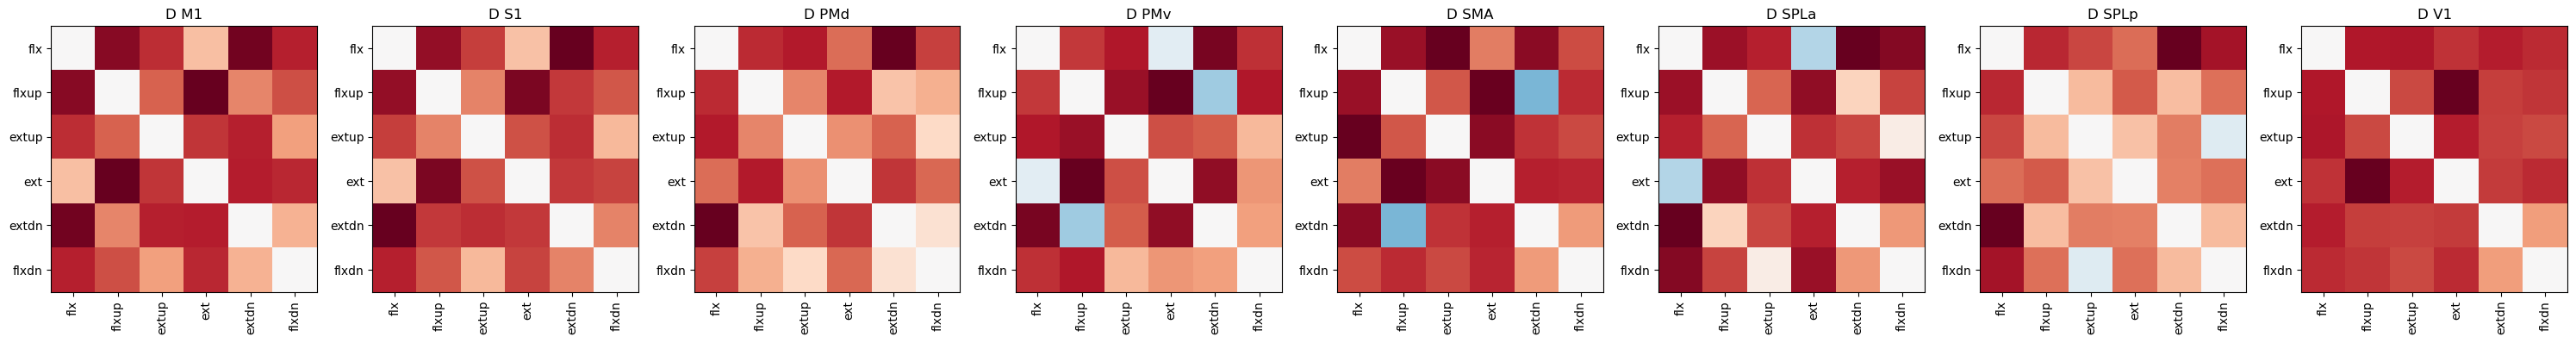

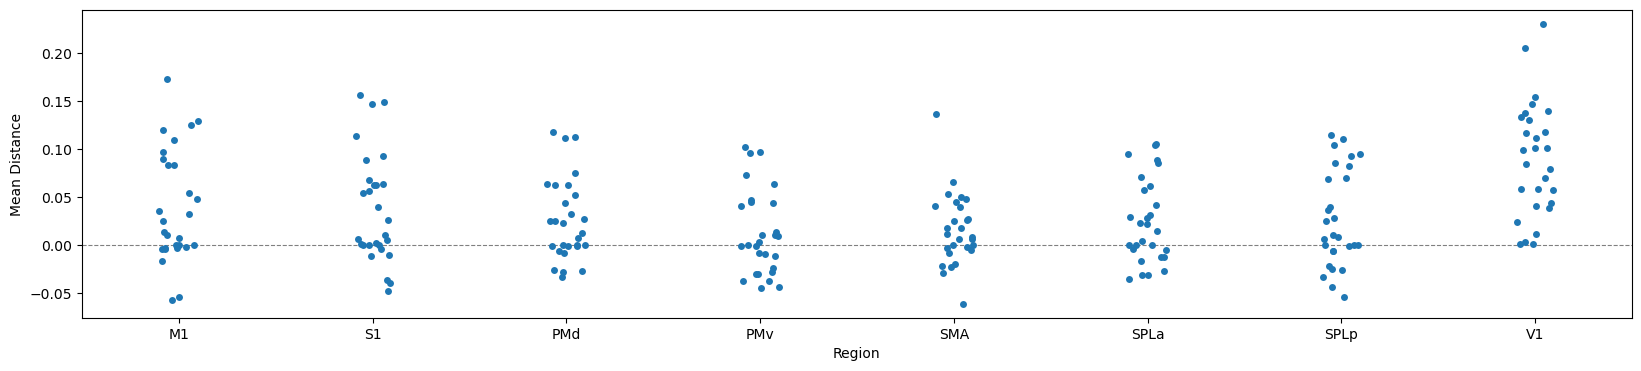

In [18]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
cmap = 'RdBu_r'
sn_bad = []
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
conditions = ['rhand','lhand']
df = {'distances':[], 'mean_distance':[], 'roi':[], 'sn':[]}

fig, axes = plt.subplots(1, len(regions), figsize=(30,6))
for i_region, region in enumerate(regions):
    rois = [f'{region}_L', f'{region}_R']
    data, cond_vec, part_vec = [], [], []
    for roi, condition in zip(rois, conditions):
        file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
        d = np.load(file_path, allow_pickle=True)

        subject = d['subject']
        indices = [k for k, s in enumerate(subject) if s not in sn_bad]

        subject = d['subject'][indices]
        cond_name_tmp = d['cond_intrinsic_vec'][indices]
        cond_vec_tmp = d['cond_num_vec'][indices]
        data_tmp = d['beta_white'][indices]
        part_tmp = d['part_vec'][indices]

        for i_sub in range(len(subject)):
            # Filter for the current condition
            if condition == 'lhand_marginal':
                Y = []
                subj_part = []
                subj_cond = []
                # loop on each direction
                for cond_num, direction in enumerate(labels):
                    # in each partition:
                    for k in range(1,11):
                        # bimanual trials that left hand goes in that direction:
                        tmp_name = f'bi:{direction}_'
                        idx1 = np.array([(tmp_name in tmp) for tmp in cond_name_tmp[i_sub]])
                        idx2 = np.array([(k == tmp) for tmp in part_tmp[i_sub]])
                        idx = idx1 & idx2
                        y_tmp = np.mean(data_tmp[i_sub][idx,:], axis=0)
                        Y = np.vstack((Y, y_tmp)) if len(Y) else y_tmp
                    subj_part = np.int64(np.concatenate((subj_part,np.arange(1,11))))
                    condition_name = f'lhand:{direction}'
                    # find the condition numbers corresponding to this condition:
                    idx = (cond_name_tmp[i_sub] == condition_name) & (part_tmp[i_sub] == 1)
                    subj_cond.extend([cond_vec_tmp[i_sub][idx][0]] * 10)

            if condition == 'rhand_marginal':
                Y = []
                subj_part = []
                subj_cond = []
                # loop on each direction
                for cond_num, direction in enumerate(labels):
                    # in each partition:
                    for k in range(1,11):
                        # bimanual trials that right hand goes in that direction:
                        tmp_name = f'_{direction}'
                        idx1 = np.array([(tmp_name in tmp) for tmp in cond_name_tmp[i_sub]])
                        idx2 = np.array([(k == tmp) for tmp in part_tmp[i_sub]])
                        idx = idx1 & idx2
                        y_tmp = np.mean(data_tmp[i_sub][idx,:], axis=0)
                        Y = np.vstack((Y, y_tmp)) if len(Y) else y_tmp
                    subj_part = np.int64(np.concatenate((subj_part,np.arange(1,11))))
                    condition_name = f'rhand:{direction}'
                    # find the condition numbers corresponding to this condition:
                    idx = (cond_name_tmp[i_sub] == condition_name) & (part_tmp[i_sub] == 1)
                    subj_cond.extend([cond_vec_tmp[i_sub][idx][0]] * 10)

            if condition == 'lhand' or condition == 'rhand':
                # Filter for the current condition
                idx = [j for j, c in enumerate(cond_name_tmp[i_sub]) if condition in c]
                Y = data_tmp[i_sub][idx, :]
                subj_cond = cond_vec_tmp[i_sub][idx]
                subj_part = part_tmp[i_sub][idx]

            data.append(Y)
            cond_vec.append(np.array(subj_cond))
            part_vec.append(subj_part)

    Y = []
    # --- RDM Calculation ---
    for i_sub in range(len(data)):
        obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
        Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))
    
    N = len(Y)
    ncond = 6
    G_hat = np.zeros((N, ncond, ncond))
    for i_sub in range(N):
        G_hat[i_sub, :, :], _ = pcm.est_G_crossval(Y[i_sub].measurements,
                                                    Y[i_sub].obs_descriptors['cond_vec'],
                                                    Y[i_sub].obs_descriptors['part_vec'],
                                                    X=pcm.matrix.indicator(Y[i_sub].obs_descriptors['part_vec']))
        dist = pcm.G_to_dist(G_hat[i_sub, :, :])
        dist = np.sign(dist) * np.sqrt(np.abs(dist))
        # select the upper triangle of d excluding the diagonal
        triu_indices = np.triu_indices(ncond, k=1)
        d_upper = dist[triu_indices]
        # save in df:
        df['distances'].append(d_upper)
        df['mean_distance'].append(np.mean(d_upper))
        df['roi'].append(region)
        # if i_sub is bigger than len of subject:
        if i_sub > len(subject)-1:
            df['sn'].append(subject[i_sub - len(subject)])
        else:
            df['sn'].append(subject[i_sub])

    G_hat_avg = np.mean(G_hat, axis=0)
    D_avg = pcm.G_to_dist(G_hat_avg)
    D_avg = np.sign(D_avg) * np.sqrt(np.abs(D_avg))

    vmin = -np.max(np.abs(D_avg))
    vmax = np.max(np.abs(D_avg))
    axes[i_region].imshow(D_avg, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    # plt.colorbar(axes[i_region].imshow(G, cmap='RdBu_r', vmin=vmin, vmax=vmax), ax=axes[i_region])
    axes[i_region].set_title(f'D {region}')
    axes[i_region].set_xticks([0,1,2,3,4,5])
    axes[i_region].set_xticklabels(labels, rotation=90)
    axes[i_region].set_yticks([0,1,2,3,4,5])
    axes[i_region].set_yticklabels(labels)

plt.tight_layout()
plt.show()

df = pd.DataFrame(df)
# Create a dot plot for the mean distances
fig, ax = plt.subplots(figsize=(20, 4))
ax.axhline(0, color='grey', linestyle='--', linewidth=0.8)
sns.stripplot(data=df, x='roi', y='mean_distance', dodge=True, jitter=True, ax=ax, legend=False)
ax.set_xlabel('Region')
ax.set_ylabel('Mean Distance')
plt.show()



# Marginal contra

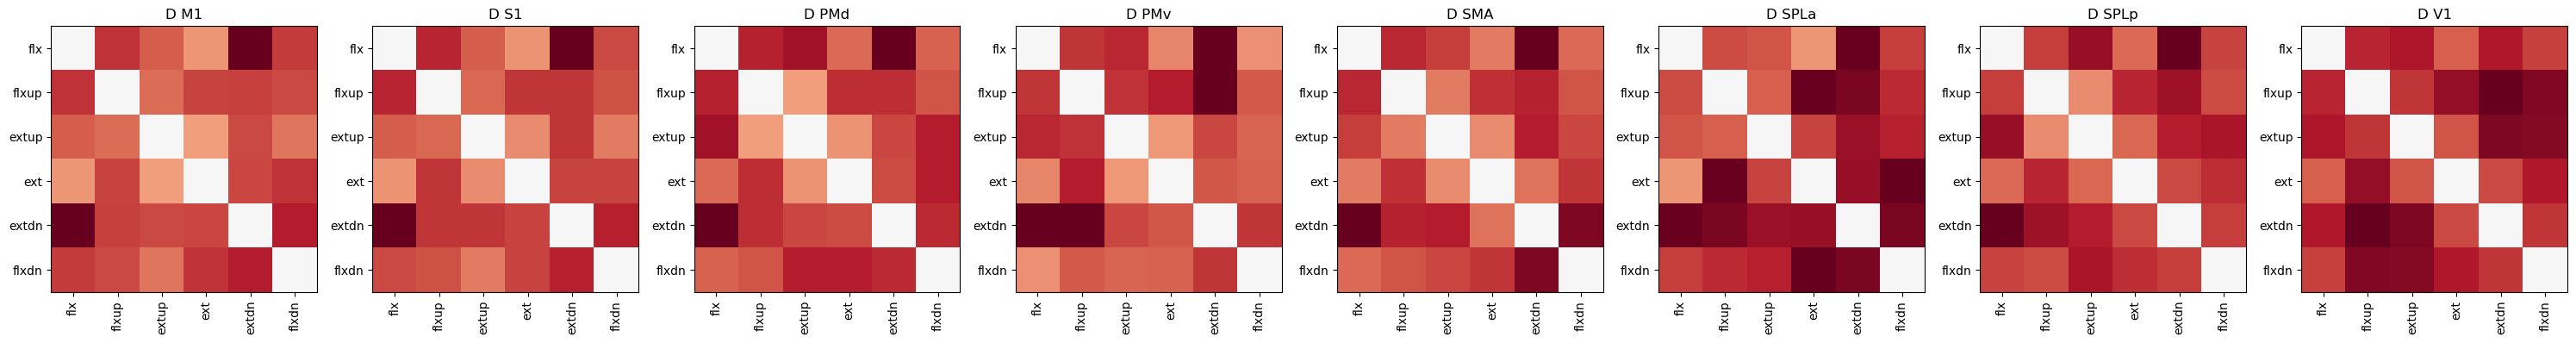

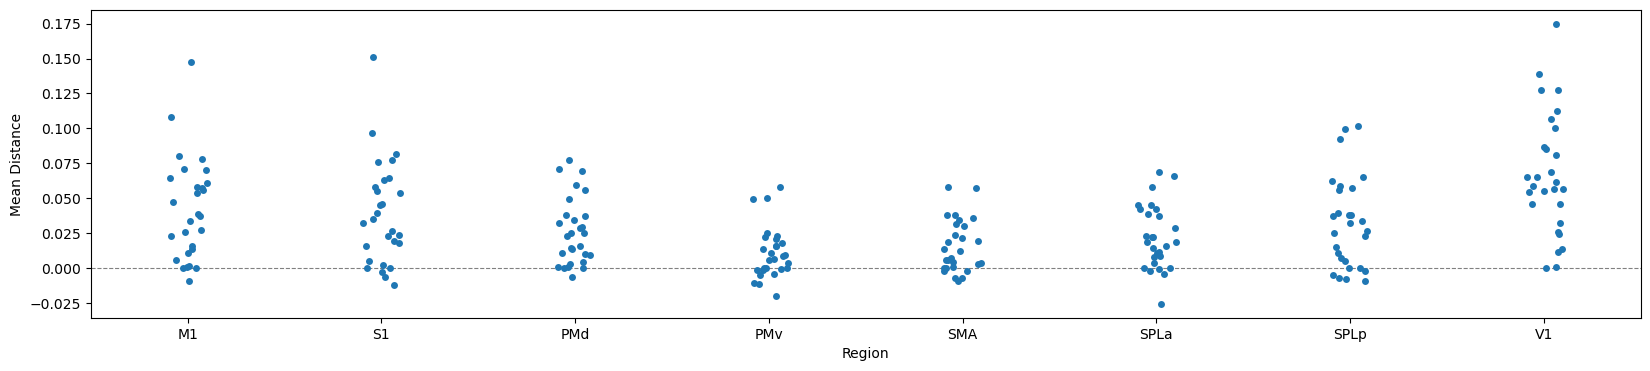

In [17]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
cmap = 'RdBu_r'
sn_bad = []
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
conditions = ['rhand_marginal','lhand_marginal']
df = {'distances':[], 'mean_distance':[], 'roi':[], 'cond':[], 'sn':[]}

fig, axes = plt.subplots(1, len(regions), figsize=(30,6))
for i_region, region in enumerate(regions):
    rois = [f'{region}_L', f'{region}_R']
    data, cond_vec, part_vec = [], [], []
    for roi, condition in zip(rois, conditions):
        file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
        d = np.load(file_path, allow_pickle=True)

        subject = d['subject']
        indices = [k for k, s in enumerate(subject) if s not in sn_bad]

        subject = d['subject'][indices]
        cond_name_tmp = d['cond_intrinsic_vec'][indices]
        cond_vec_tmp = d['cond_num_vec'][indices]
        data_tmp = d['beta_white'][indices]
        part_tmp = d['part_vec'][indices]

        for i_sub in range(len(subject)):
            # Filter for the current condition
            if condition == 'lhand_marginal':
                Y = []
                subj_part = []
                subj_cond = []
                # loop on each direction
                for cond_num, direction in enumerate(labels):
                    # in each partition:
                    for k in range(1,11):
                        # bimanual trials that left hand goes in that direction:
                        tmp_name = f'bi:{direction}_'
                        idx1 = np.array([(tmp_name in tmp) for tmp in cond_name_tmp[i_sub]])
                        idx2 = np.array([(k == tmp) for tmp in part_tmp[i_sub]])
                        idx = idx1 & idx2
                        y_tmp = np.mean(data_tmp[i_sub][idx,:], axis=0)
                        Y = np.vstack((Y, y_tmp)) if len(Y) else y_tmp
                    subj_part = np.int64(np.concatenate((subj_part,np.arange(1,11))))
                    condition_name = f'lhand:{direction}'
                    # find the condition numbers corresponding to this condition:
                    idx = (cond_name_tmp[i_sub] == condition_name) & (part_tmp[i_sub] == 1)
                    subj_cond.extend([cond_vec_tmp[i_sub][idx][0]] * 10)

            if condition == 'rhand_marginal':
                Y = []
                subj_part = []
                subj_cond = []
                # loop on each direction
                for cond_num, direction in enumerate(labels):
                    # in each partition:
                    for k in range(1,11):
                        # bimanual trials that right hand goes in that direction:
                        tmp_name = f'_{direction}'
                        idx1 = np.array([(tmp_name in tmp) for tmp in cond_name_tmp[i_sub]])
                        idx2 = np.array([(k == tmp) for tmp in part_tmp[i_sub]])
                        idx = idx1 & idx2
                        y_tmp = np.mean(data_tmp[i_sub][idx,:], axis=0)
                        Y = np.vstack((Y, y_tmp)) if len(Y) else y_tmp
                    subj_part = np.int64(np.concatenate((subj_part,np.arange(1,11))))
                    condition_name = f'rhand:{direction}'
                    # find the condition numbers corresponding to this condition:
                    idx = (cond_name_tmp[i_sub] == condition_name) & (part_tmp[i_sub] == 1)
                    subj_cond.extend([cond_vec_tmp[i_sub][idx][0]] * 10)

            if condition == 'lhand' or condition == 'rhand':
                # Filter for the current condition
                idx = [j for j, c in enumerate(cond_name_tmp[i_sub]) if condition in c]
                Y = data_tmp[i_sub][idx, :]
                subj_cond = cond_vec_tmp[i_sub][idx]
                subj_part = part_tmp[i_sub][idx]

            data.append(Y)
            cond_vec.append(np.array(subj_cond))
            part_vec.append(subj_part)

    Y = []
    # --- RDM Calculation ---
    for i_sub in range(len(data)):
        obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
        Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))
    
    N = len(Y)
    ncond = 6
    G_hat = np.zeros((N, ncond, ncond))
    for i_sub in range(N):
        G_hat[i_sub, :, :], _ = pcm.est_G_crossval(Y[i_sub].measurements,
                                                    Y[i_sub].obs_descriptors['cond_vec'],
                                                    Y[i_sub].obs_descriptors['part_vec'],
                                                    X=pcm.matrix.indicator(Y[i_sub].obs_descriptors['part_vec']))
        dist = pcm.G_to_dist(G_hat[i_sub, :, :])
        dist = np.sign(dist) * np.sqrt(np.abs(dist))
        # select the upper triangle of d excluding the diagonal
        triu_indices = np.triu_indices(ncond, k=1)
        d_upper = dist[triu_indices]
        # save in df:
        df['distances'].append(d_upper)
        df['mean_distance'].append(np.mean(d_upper))
        df['roi'].append(region)
        df['cond'].append(condition)
        # if i_sub is bigger than len of subject:
        if i_sub > len(subject)-1:
            df['sn'].append(subject[i_sub - len(subject)])
        else:
            df['sn'].append(subject[i_sub])

    G_hat_avg = np.mean(G_hat, axis=0)
    D_avg = pcm.G_to_dist(G_hat_avg)
    D_avg = np.sign(D_avg) * np.sqrt(np.abs(D_avg))

    vmin = -np.max(np.abs(D_avg))
    vmax = np.max(np.abs(D_avg))
    axes[i_region].imshow(D_avg, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    # plt.colorbar(axes[i_region].imshow(G, cmap='RdBu_r', vmin=vmin, vmax=vmax), ax=axes[i_region])
    axes[i_region].set_title(f'D {region}')
    axes[i_region].set_xticks([0,1,2,3,4,5])
    axes[i_region].set_xticklabels(labels, rotation=90)
    axes[i_region].set_yticks([0,1,2,3,4,5])
    axes[i_region].set_yticklabels(labels)

plt.tight_layout()
plt.show()

df = pd.DataFrame(df)
# Create a dot plot for the mean distances
fig, ax = plt.subplots(figsize=(20, 4))
ax.axhline(0, color='grey', linestyle='--', linewidth=0.8)
sns.stripplot(data=df, x='roi', y='mean_distance', dodge=True, jitter=True, ax=ax, legend=False)
ax.set_xlabel('Region')
ax.set_ylabel('Mean Distance')
plt.show()




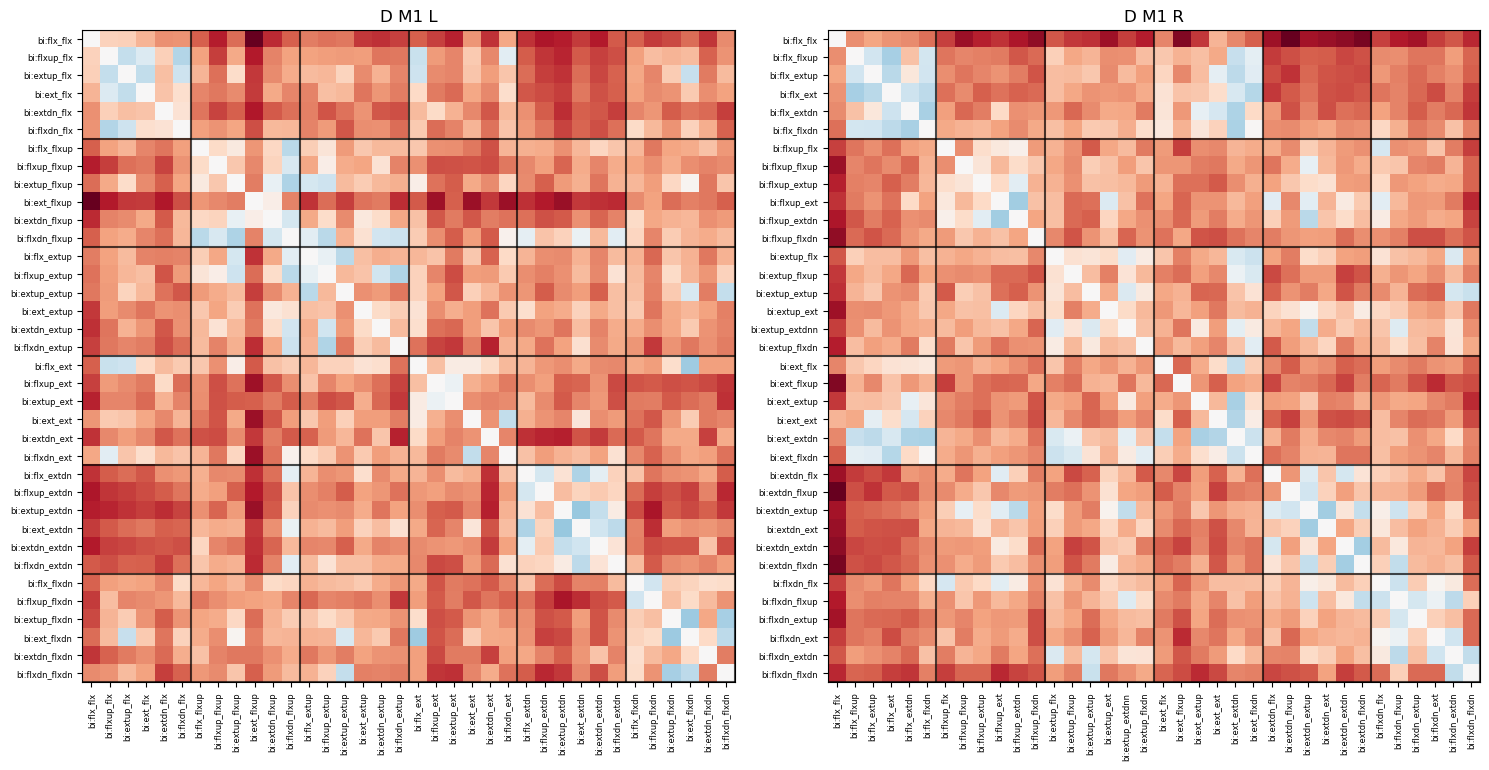

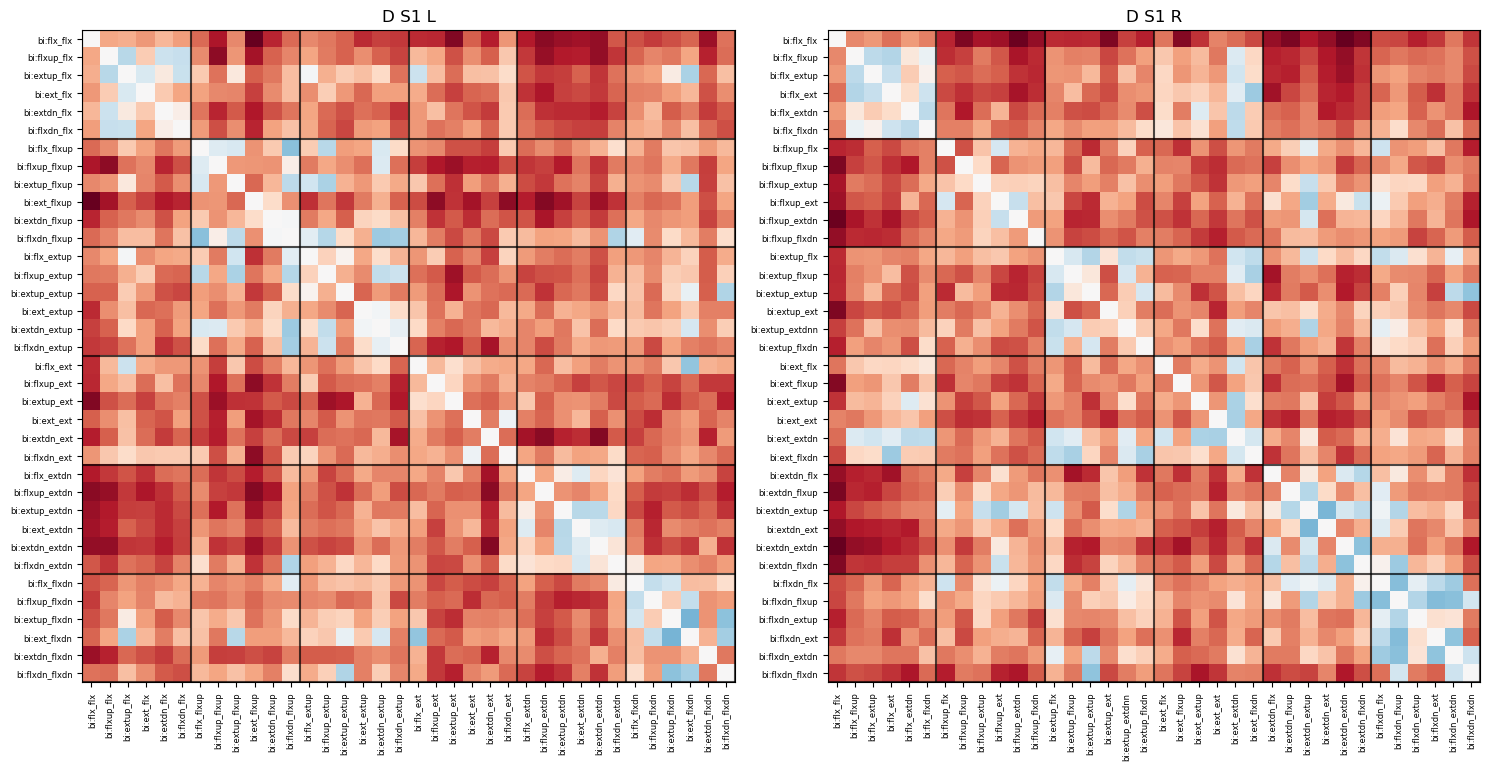

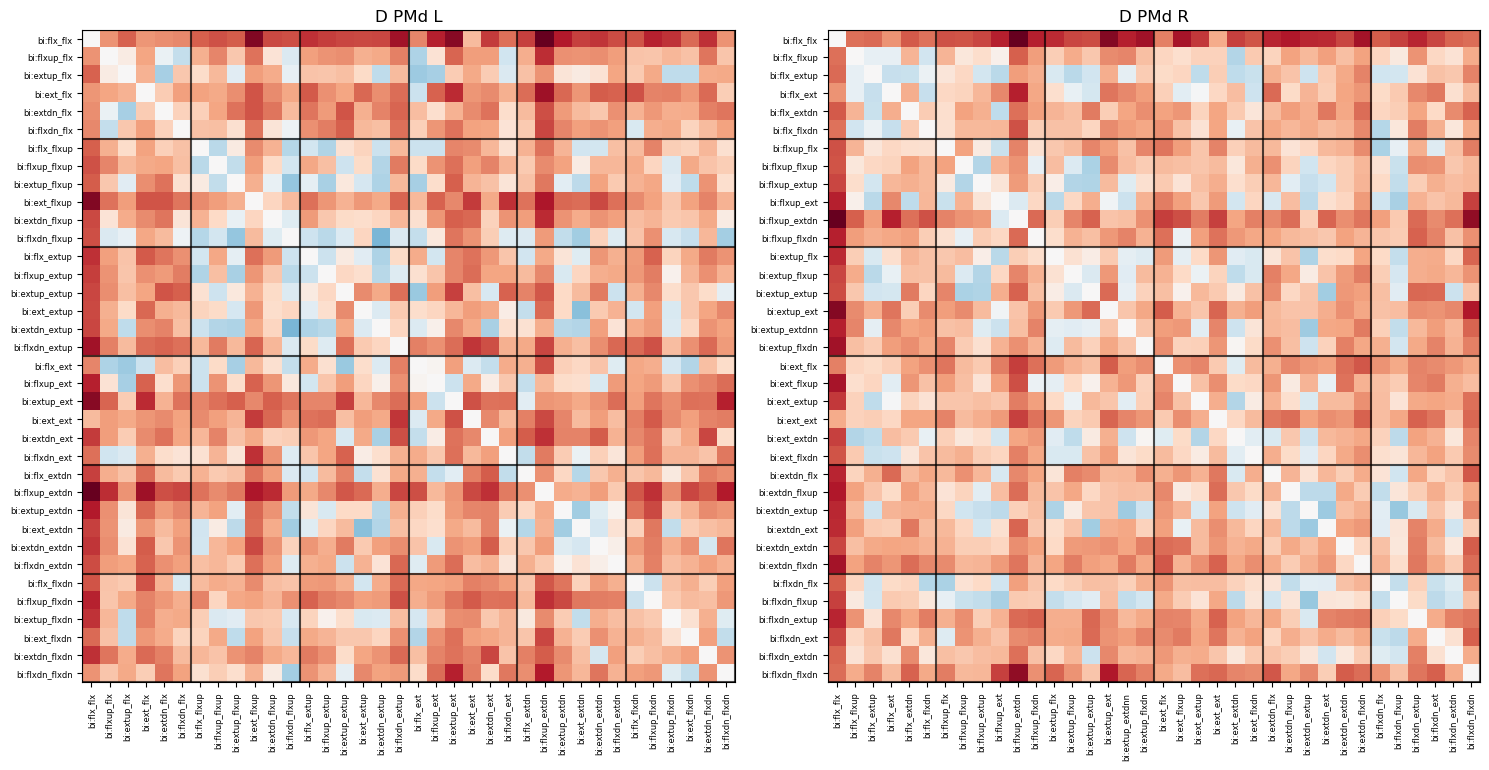

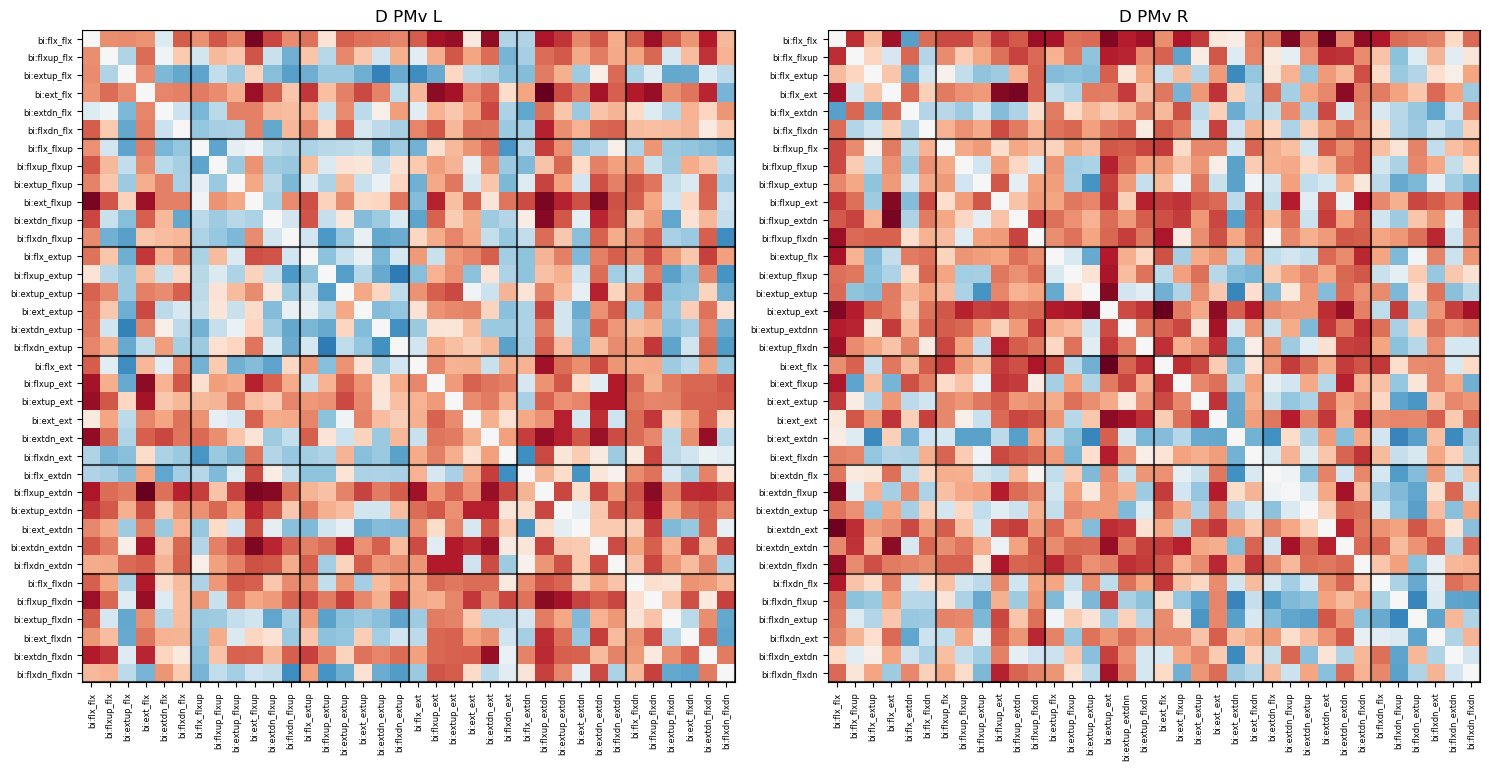

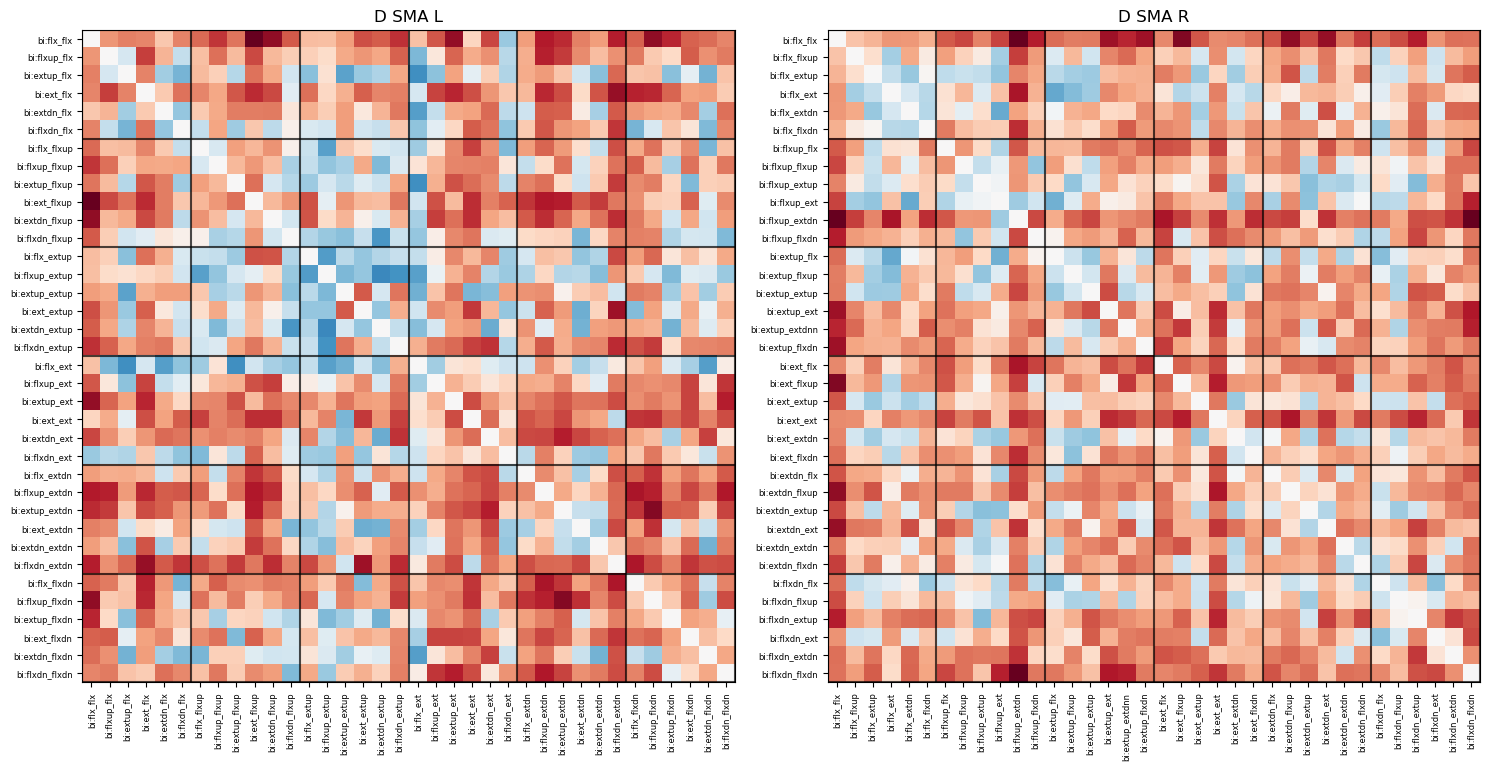

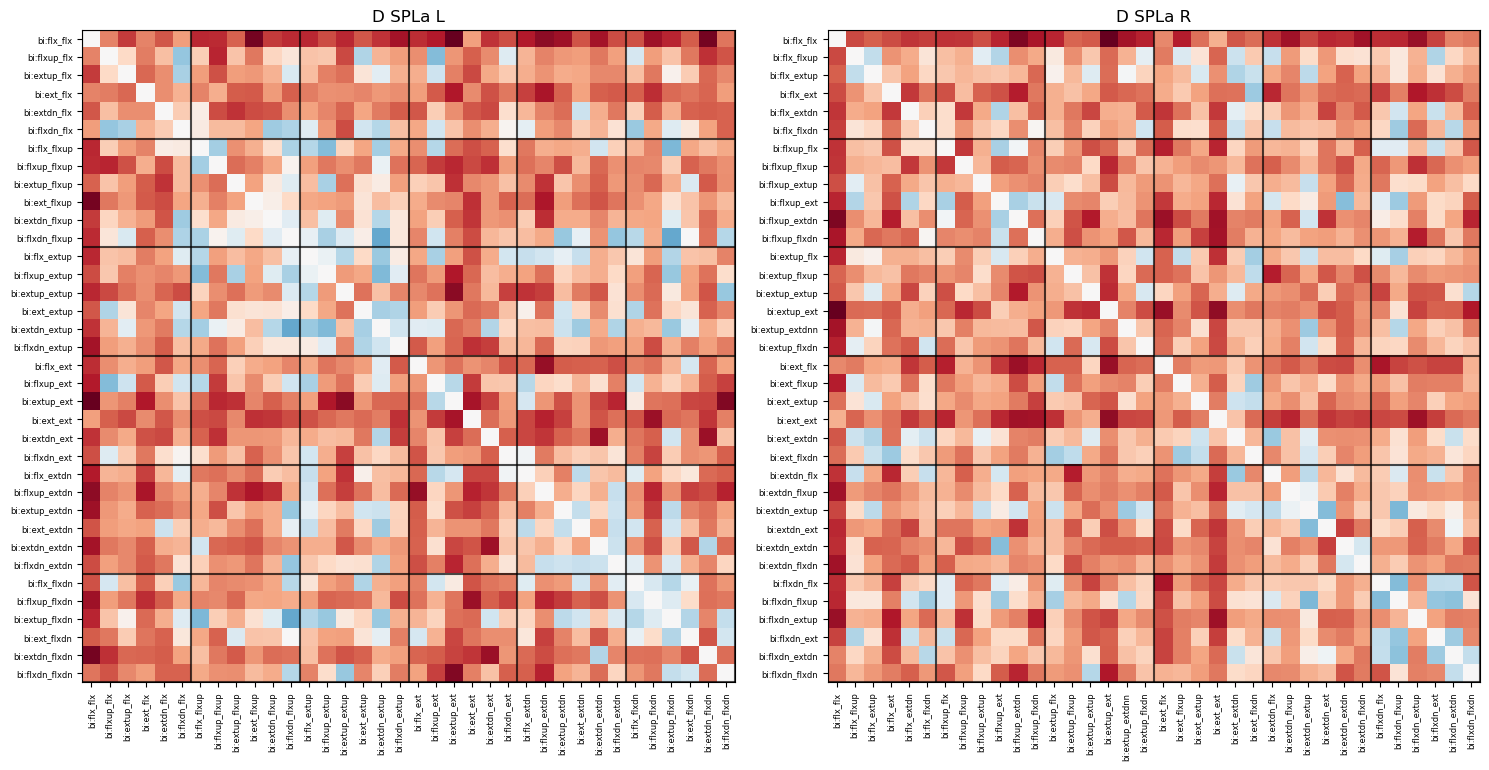

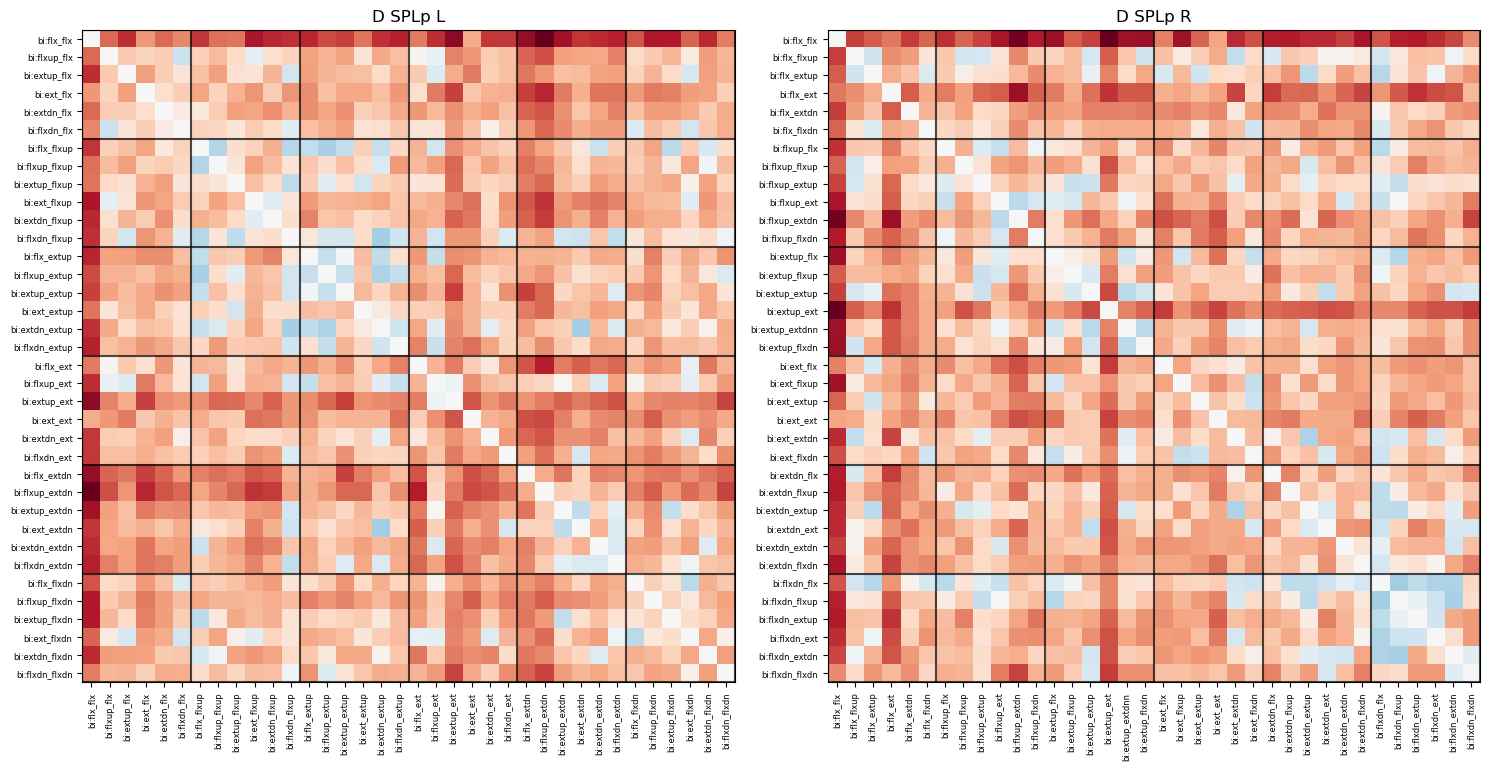

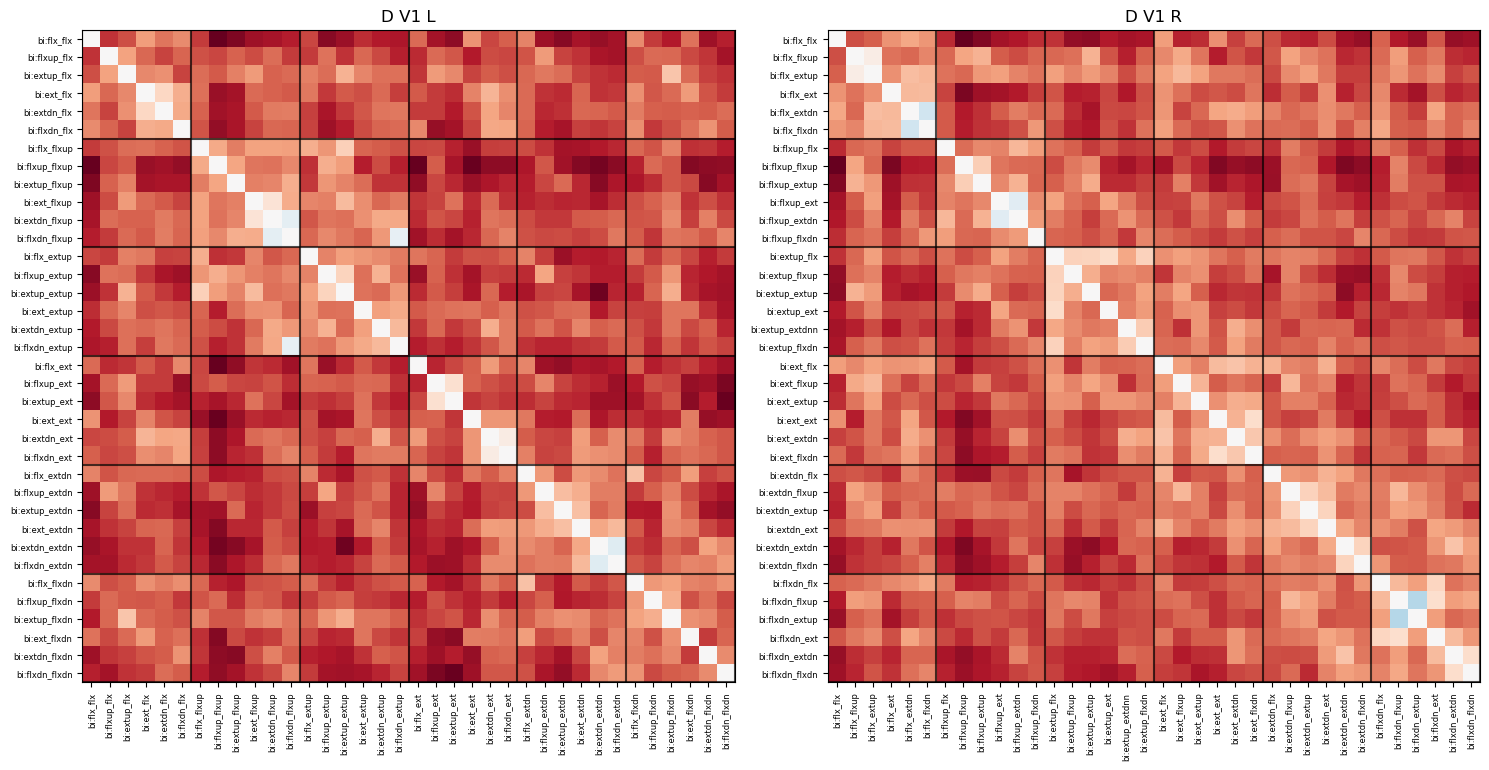

In [49]:
labels = {'L': ['bi:flx_flx', 'bi:flxup_flx', 'bi:extup_flx', 'bi:ext_flx', 'bi:extdn_flx', 'bi:flxdn_flx', 
                'bi:flx_flxup', 'bi:flxup_flxup', 'bi:extup_flxup', 'bi:ext_flxup', 'bi:extdn_flxup', 'bi:flxdn_flxup', 
                'bi:flx_extup', 'bi:flxup_extup', 'bi:extup_extup', 'bi:ext_extup', 'bi:extdn_extup', 'bi:flxdn_extup', 
                'bi:flx_ext', 'bi:flxup_ext', 'bi:extup_ext', 'bi:ext_ext', 'bi:extdn_ext', 'bi:flxdn_ext', 
                'bi:flx_extdn', 'bi:flxup_extdn', 'bi:extup_extdn', 'bi:ext_extdn', 'bi:extdn_extdn', 'bi:flxdn_extdn', 
                'bi:flx_flxdn', 'bi:flxup_flxdn', 'bi:extup_flxdn', 'bi:ext_flxdn', 'bi:extdn_flxdn', 'bi:flxdn_flxdn' ],

          'R': ['bi:flx_flx',    'bi:flx_flxup',   'bi:flx_extup',   'bi:flx_ext',   'bi:flx_extdn',   'bi:flx_flxdn',
                'bi:flxup_flx',  'bi:flxup_flxup', 'bi:flxup_extup', 'bi:flxup_ext', 'bi:flxup_extdn', 'bi:flxup_flxdn',
                'bi:extup_flx',  'bi:extup_flxup', 'bi:extup_extup', 'bi:extup_ext', 'bi:extup_extdnn', 'bi:extup_flxdn',
                'bi:ext_flx',    'bi:ext_flxup',   'bi:ext_extup',   'bi:ext_ext',   'bi:ext_extdn',   'bi:ext_flxdn',
                'bi:extdn_flx',  'bi:extdn_flxup', 'bi:extdn_extup', 'bi:extdn_ext', 'bi:extdn_extdn', 'bi:extdn_flxdn',
                'bi:flxdn_flx',  'bi:flxdn_flxup', 'bi:flxdn_extup', 'bi:flxdn_ext', 'bi:flxdn_extdn', 'bi:flxdn_flxdn']
}

cmap = 'RdBu_r'
sn_bad = []
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']

for i_region, region in enumerate(regions):
    fig, axes = plt.subplots(1, 2, figsize=(15,8))
    # enumerate hemispheres so we get an integer index for axes
    for hem_idx, hem in enumerate(['L','R']):
        roi = f'{region}_{hem}'
        data, cond_vec, part_vec = [], [], []
        file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
        d = np.load(file_path, allow_pickle=True)

        subject = d['subject']
        indices = [k for k, s in enumerate(subject) if s not in sn_bad]

        subject = d['subject'][indices]
        cond_name_tmp = d['cond_intrinsic_vec'][indices]
        if hem == 'R':
            cond_vec_tmp = d['cond_num_vec'][indices]
        else:
            cond_vec_tmp = d['cond_num_lhem_bimanual_vec']
        data_tmp = d['beta_white'][indices]
        part_tmp = d['part_vec'][indices]

        for i_sub in range(len(subject)):
            # Filter for the current condition
            idx = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'bi' in c]
            Y = data_tmp[i_sub][idx, :]
            subj_cond = cond_vec_tmp[i_sub][idx]
            subj_part = part_tmp[i_sub][idx]

            data.append(Y)
            cond_vec.append(np.array(subj_cond))
            part_vec.append(subj_part)

        Y = []
        # --- RDM Calculation ---
        for i_sub in range(len(data)):
            obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
            Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))
        
        N = len(Y)
        ncond = 36
        G_hat = np.zeros((N, ncond, ncond))
        for i_sub in range(N):
            G_hat[i_sub, :, :], _ = pcm.est_G_crossval(Y[i_sub].measurements,
                                                        Y[i_sub].obs_descriptors['cond_vec'],
                                                        Y[i_sub].obs_descriptors['part_vec'],
                                                        X=pcm.matrix.indicator(Y[i_sub].obs_descriptors['part_vec']))

        G_hat_avg = np.mean(G_hat, axis=0)
        D_avg = pcm.G_to_dist(G_hat_avg)
        D_avg = np.sign(D_avg) * np.sqrt(np.abs(D_avg))

        vmin = -np.max(np.abs(D_avg))
        vmax = np.max(np.abs(D_avg))
        axes[hem_idx].imshow(D_avg, cmap=cmap, vmin=vmin, vmax=vmax)
        # plt.colorbar(axes[i_region].imshow(G, cmap='RdBu_r', vmin=vmin, vmax=vmax), ax=axes[i_region])
        axes[hem_idx].set_title(f'D {region} {hem}')
        axes[hem_idx].set_xticks(list(range(36)))
        axes[hem_idx].set_yticks(list(range(36)))
        axes[hem_idx].set_yticklabels(labels[hem], fontsize=6)
        axes[hem_idx].set_xticklabels(labels[hem], rotation=90, fontsize=6)
        # Add thin borders delineating each 6x6 block
        block = 6
        bounds = [i * block - 0.5 for i in range(ncond // block + 1)]
        for b in bounds:
            axes[hem_idx].axhline(b, color='k', lw=1.5, alpha=0.7)
            axes[hem_idx].axvline(b, color='k', lw=1.5, alpha=0.7)

    plt.tight_layout()
    plt.savefig(os.path.join(analysisDir, f'bimanual_{region}.pdf'), bbox_inches='tight')
    plt.show()

